# Food Classification with CNN - Building a Restaurant Recommendation System

This assignment focuses on developing a deep learning-based food classification system using Convolutional Neural Networks (CNNs). You will build a model that can recognize different food categories and use it to return the food preferences of a user.

## Learning Objectives
- Implement CNNs for image classification
- Work with real-world food image datasets
- Build a preference-detector system

## Background: AI-Powered Food Preference Discovery

The system's core idea is simple:

1. Users upload 10 photos of dishes they enjoy
2. Your CNN classifies these images into the 91 categories
3. Based on these categories, the system returns the user's taste profile

Your task is to develop the core computer vision component that will power this detection engine.

You are given a training ("train" folder) and a test ("test" folder) dataset which have ~45k and ~22k samples respectively. For each one of the 91 classes there is a subdirectory containing the images of the respective class.

## Assignment Requirements

### Technical Requirements
- Implement your own pytorch CNN architecture for food image classification
- Use only the provided training dataset split for training
- Train the network from scratch ; No pretrained weights can be used
- Report test-accuracy after every epoch
- Report all hyperparameters of final model
- Use a fixed seed and do not use any CUDA-features that break reproducibility
- Use Pytorch 2.6

### Deliverables
1. Jupyter Notebook with CNN implementation, training code etc.
2. README file
3. Report (max 3 pages)

Submit your report, README and all code files as a single zip file named GROUP_[number]_NC2425_PA. The names and IDs of the group components must be mentioned in the README.
Do not include the dataset in your submission.

### Grading

1. Correct CNN implementation, training runs on the uni DSLab computers according to the README.MD instructions without ANY exceptions on the DSLab machines: 3pt
2. Perfect 1:1 reproducibility on DSLab machines: 1pt
3. Very clear github-repo-style README.MD with instructions for running the code: 1pt
4. Report: 1pt
5. Model test performance on test-set: interpolated from 30-80% test-accuracy: 0-3pt
6. Pick 10 random pictures of the test set to simulate a user uploading images and report which categories occur how often in these: 1pt
7. Bonus point: use an LLM (API) to generate short description / profile of preferences of the simulated user

**If there is anything unclear about this assignment please post your question in the Brightspace discussions forum or send an email**


# Loading the datasets
The dataset is already split into a train and test set in the directories "train" and "test".

In [12]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import random
import os
from collections import Counter
import matplotlib.pyplot as plt

# set seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    # For reproducibility with Conv2d
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# set initial seed
set_seed(42)

2.6.0+cu126
True
NVIDIA GeForce RTX 3070 Laptop GPU


In [13]:
# data augmentation
transform_train = transforms.Compose([
    # by transforming the train data partially random 
    # we get a more varied dataset that leads to better performance
    transforms.Resize((144, 144)),
    transforms.RandomCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    # transform similarly except for the random changes
    transforms.Resize((144, 144)),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# load datasets
train_dataset = datasets.ImageFolder('train', transform=transform_train)
test_dataset = datasets.ImageFolder('test', transform=transform_test)

# create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# print dataset info
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")

Number of training samples: 45727
Number of test samples: 22523
Number of classes: 91


# CNN Implementation

In [14]:
class FoodCNN(nn.Module):
    def __init__(self):
        num_classes = 91
        super(FoodCNN, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # added extra conv
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.4),
            # Transform to final 91 classes
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

# Training the model
Implement your training process below. Report the test-accuracy after every epoch for the training run of the final model.

Hint: before training your model make sure to reset the seed in the training cell, as otherwise the seed may have changed due to previous training runs in the notebook

Note: If you implement automatic hyperparameter tuning, split the train set into train and validation subsets for the objective function.

In [ ]:
def train_and_evaluate(model, train_loader, test_loader, num_epochs=30, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = model.to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.05)  # light label smoothing
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)

    # OneCycleLR as a scheduler
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=0.003,
        epochs=num_epochs,
        steps_per_epoch=len(train_loader),
        pct_start=0.3,
        div_factor=10,
        final_div_factor=100
    )

    # best accuracy to compare models
    best_acc = 0.0

    for epoch in range(num_epochs):
        # training phase
        model.train()
        running_loss = 0.0

        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()  # 1 step per batch

            running_loss += loss.item()

        # evaluation phase
        test_acc = evaluate(model, test_loader)
        current_lr = optimizer.param_groups[0]['lr']

        # print current performance and epoch
        print(f"Epoch {epoch+1}/{num_epochs}, Test Accuracy: {test_acc:.4f}, LR: {current_lr:.6f}")

        # save best model if its better than previous best
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"Saved new best model with accuracy {best_acc:.4f}")

    return best_acc

# evaluation function
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    device = next(model.parameters()).device

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)
    return correct / total

In [16]:
# reset seed for training
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

model = FoodCNN().to(device)

# train the model
num_epochs = 50
learning_rate = 0.001
best_accuracy = train_and_evaluate(model, train_loader, test_loader, num_epochs=num_epochs, lr=learning_rate)

Device: cuda
Using device: cuda
Epoch 1/50, Test Accuracy: 0.1214, LR: 0.000330
Saved new best model with accuracy 0.1214
Epoch 2/50, Test Accuracy: 0.1625, LR: 0.000417
Saved new best model with accuracy 0.1625
Epoch 3/50, Test Accuracy: 0.1868, LR: 0.000558
Saved new best model with accuracy 0.1868
Epoch 4/50, Test Accuracy: 0.2669, LR: 0.000747
Saved new best model with accuracy 0.2669
Epoch 5/50, Test Accuracy: 0.2671, LR: 0.000975
Saved new best model with accuracy 0.2671
Epoch 6/50, Test Accuracy: 0.3007, LR: 0.001233
Saved new best model with accuracy 0.3007
Epoch 7/50, Test Accuracy: 0.2583, LR: 0.001509
Epoch 8/50, Test Accuracy: 0.2831, LR: 0.001791
Epoch 9/50, Test Accuracy: 0.3502, LR: 0.002067
Saved new best model with accuracy 0.3502
Epoch 10/50, Test Accuracy: 0.3636, LR: 0.002325
Saved new best model with accuracy 0.3636
Epoch 11/50, Test Accuracy: 0.3760, LR: 0.002553
Saved new best model with accuracy 0.3760
Epoch 12/50, Test Accuracy: 0.3697, LR: 0.002742
Epoch 13/50

In [ ]:
# load the best model weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FoodCNN().to(device)
model.load_state_dict(torch.load("best_model.pth"))

# calculate final test accuracy
final_test_acc = evaluate(model, test_loader)
print(f"Final Test Accuracy: {final_test_acc * 100:.2f}%")

Final Test Accuracy: 62.36%


# Calculating model performance
Load the best version of your model ( which should be produced and saved by previous cells ), calculate and report the test accuracy.

In [ ]:
# load the best model weights
model = FoodCNN().to(device)
model.load_state_dict(torch.load("best_model.pth"))

def calculate_test_accuracy(model):
    "Takes the average and standard deviation of 5 tests to find a better accuracy"
    acc_list = []
    for i in range(5):
        acc_list.append(evaluate(model, test_loader))
    avg = np.average(acc_list)
    std = np.std(acc_list)
    return avg, std

    
final_test_acc, final_test_std = calculate_test_accuracy(model)

print(f"Final Test Accuracy: {final_test_acc * 100:.2f}% +- {final_test_std*100:.2f}%")


Final Test Accuracy: 62.36% +- 0.00%


# Summary of hyperparameters
Report the hyperparameters ( learning rate etc ) that you used in your final model for reproducibility.

In [ ]:
# summary of hyperparameters
print("Hyperparameters Summary:")
print("-" * 30)
print(f"Architecture: Custom CNN with deeper layers")
print(f"Number of classes: 91")
print(f"Learning rate: {learning_rate}")
print(f"Maximum learning rate: 0.003")
print(f"Weight decay: 0.0001")
print(f"Optimizer: Adam")
print(f"Batch size: 32")
print(f"Number of epochs: {num_epochs}")
print(f"Image size: 144x144")
print(f"Normalization: ImageNet mean/std")
print(f"Dropout rate: 0.4 (classifier)")
print(f"Learning rate scheduler: OneCycleLR")
print(f"Early stopping patience: 5")
print("-" * 30)

Hyperparameters Summary:
------------------------------
Architecture: Custom CNN with deeper layers
Number of classes: 91
Learning rate: 0.001
Maximum learning rate: 0.003
Weight decay: 0.0001
Optimizer: Adam
Batch size: 32
Number of epochs: 50
Image size: 144x144
Normalization: ImageNet mean/std
Dropout rate: 0.4 (classifier)
Learning rate scheduler: OneCycleLR
Early stopping patience: 5
------------------------------


# Simulation of random user
Pick 10 random pictures of the test set to simulate a user uploading images and report which categories occur how often in these: 1pt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Comparing real vs predicted classes:

1. Real class: cheese_plate, Predicted class: cheese_plate


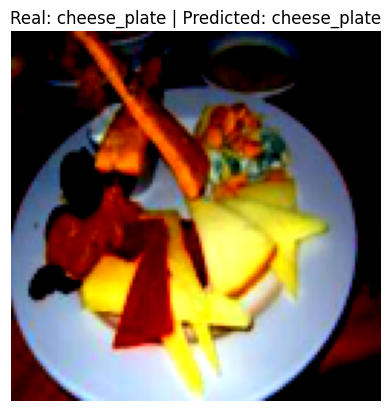

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2. Real class: red_velvet_cake, Predicted class: red_velvet_cake


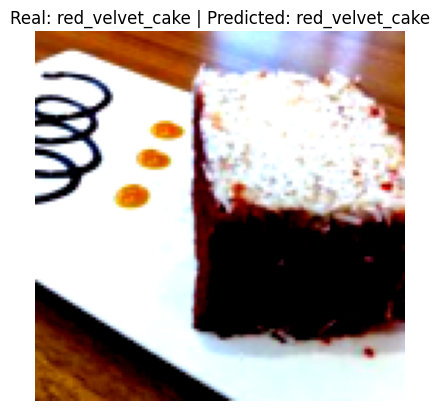

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3. Real class: lobster_roll_sandwich, Predicted class: hot_dog


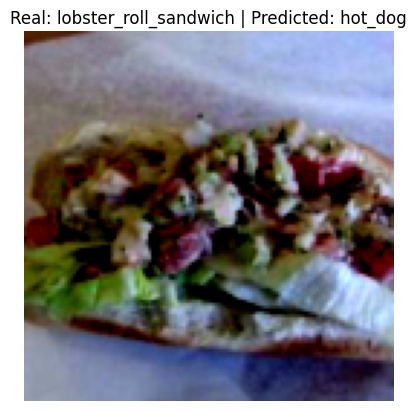

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4. Real class: breakfast_burrito, Predicted class: filet_mignon


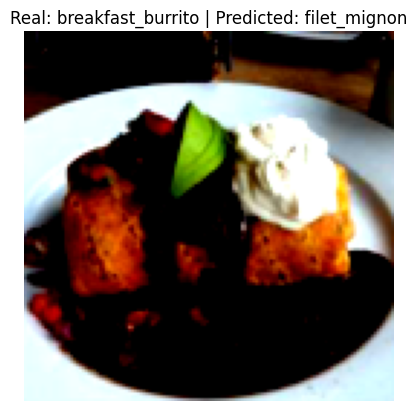

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5. Real class: bread_pudding, Predicted class: bread_pudding


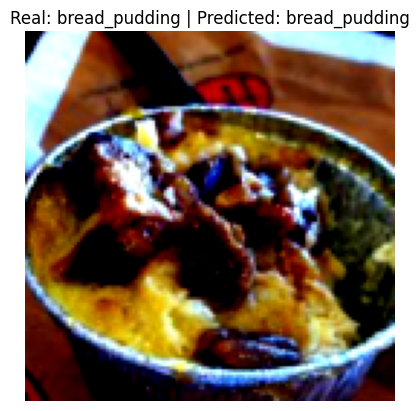

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6. Real class: cheesecake, Predicted class: cheesecake


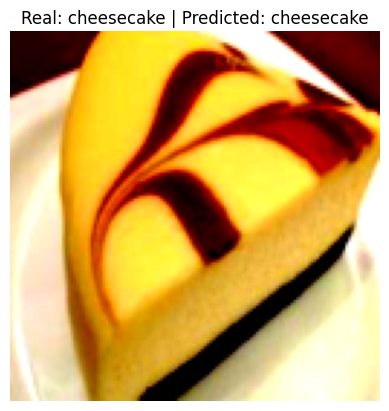

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7. Real class: eggs_benedict, Predicted class: eggs_benedict


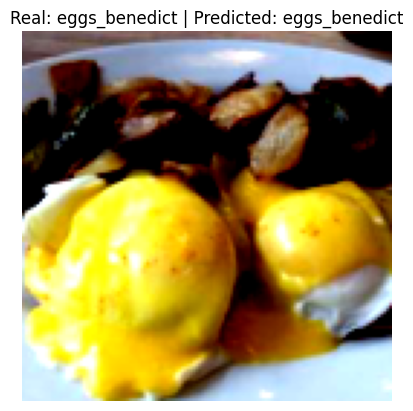

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8. Real class: falafel, Predicted class: cannoli


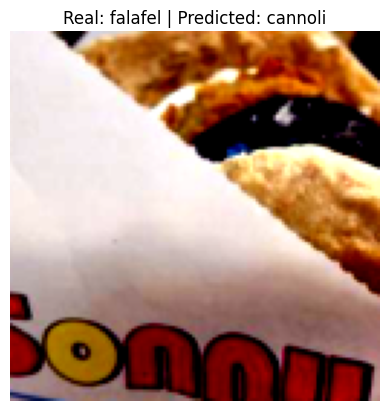

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9. Real class: pancakes, Predicted class: bread_pudding


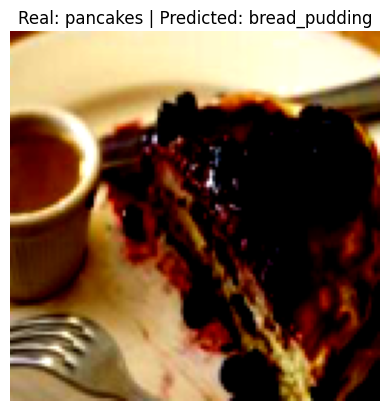

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10. Real class: samosa, Predicted class: crab_cakes


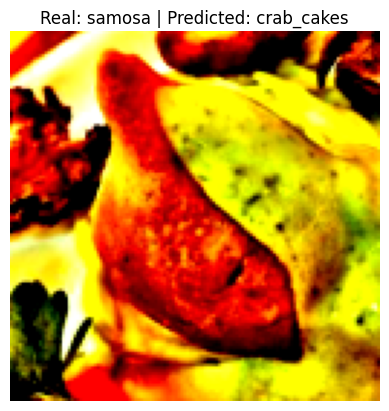

In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import Subset

# load trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FoodCNN()
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.eval().to(device)

# define the same transform as used during test
transform_test = transforms.Compose([
    transforms.Resize((144, 144)),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# load test dataset
test_dataset = datasets.ImageFolder('test', transform=transform_test)
class_names = test_dataset.classes

# pick 10 random images from the test set
indices = random.sample(range(len(test_dataset)), 10)
subset = Subset(test_dataset, indices)
loader = DataLoader(subset, batch_size=1, shuffle=False)

def imshow(tensor):
    img = tensor.cpu().clone().squeeze(0)
    img = img * 0.45 + 0.22  # unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# predict and compare with ground truth
print("Comparing real vs predicted classes:\n")

with torch.no_grad():
    for idx, (inputs, labels) in enumerate(loader):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        true_class = class_names[labels.item()]
        predicted_class = class_names[preds.item()]
        
        print(f"{idx+1}. Real class: {true_class}, Predicted class: {predicted_class}")
        imshow(inputs)
        plt.title(f"Real: {true_class} | Predicted: {predicted_class}")
        plt.show()

# Bonus point
Use an LLM (API) to generate a description of the food preference of a user based on 10 images that a potential user could provide.
Please include an example of the output of your code, especially if you used an API other than the OpenAI API.

This should work well even with differing test images by setting different random seeds for the image selector.